## Import libraries

In [78]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

## Set execution parameters

In [4]:
# Set multithreading for server
sc._settings.ScanpyConfig.n_jobs=-1
sc._settings.ScanpyConfig.max_memory=128

## Functions

In [135]:

# Scaling functions for nice colors on UMAP plots
def scaled_vmin(values): 
    print("vmin scaled to data: ", np.mean(values))
    return float(np.mean(values))

def scaled_vmax(values): 
    #vmax_scaled = float(np.max(values) - np.max(values) * 0.05)
    vmax_scaled = round(float(np.percentile(values, 99)) * 1.2, 2)
    print("vmax scaled to 99th percentile + 20%: ", vmax_scaled)
    return vmax_scaled



# Palette normalization with centering and adapted dynamic range to correspond to
# the distance of vmin and vmax from the cenetr
# Adapted from https://stackoverflow.com/a/50003503
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        value = np.array(value).astype(float)
        normalized_min = max(
            0.0,
            0.5
            * (1.0 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))),
        )
        normalized_max = min(
            1.0,
            0.5
            * (1.0 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))),
        )
        normalized_mid = 0.5
        x, y = (
            [self.vmin, self.midpoint, self.vmax],
            [normalized_min, normalized_mid, normalized_max],
        )
        return np.ma.masked_array(np.interp(value, x, y))

## Read data

In [5]:
ROOT_DIR = os.path.join("/", "home", "nikiarte", "scrnaseq")
raw_counts_path = os.path.join(ROOT_DIR, "raw_counts", "GSE130879_RAW")
h5_samples_file_path = os.path.join(raw_counts_path, "samples.txt")


In [6]:
h5_samples_file_path


'/home/nikiarte/scrnaseq/raw_counts/GSE130879_RAW/samples.txt'

In [7]:
adata_dict = {}
with open(h5_samples_file_path, 'r', encoding='utf-8') as h5_samples_file:
    for line in h5_samples_file:
        sample_id = line.split("_")[2]
        h5_sample_path = os.path.join(raw_counts_path, line[0:-1])
        sample_adata = sc.read_10x_h5(h5_sample_path)
        sample_adata.var_names_make_unique()
        adata_dict[sample_id] = sample_adata
        
adata = ad.concat(adata_dict, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata    


        

/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/nikiarte/env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.v

sample
Spleen    737280
Fat       737280
Skin      737280
Blood     737280
LN        737280
BM        737280
Lung      737280
Liver     737280
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 5898240 × 27998
    obs: 'sample'

In [8]:
adata.X.shape

(5898240, 27998)

## Preprocessing

In [9]:
# Mark mitochondrial genes
adata.var['mt'] = adata.var.index.str.startswith('mt-')
# Mark ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("^Rp[sl][[:digit:]]|^Rp[[:digit:]]|^Rpsa"))
# Mark hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p, e, s)]")

In [10]:
# Filter genes with lower than 3 reads
sc.pp.filter_genes(adata, min_cells=3)
# Remove cells with few reads
sc.pp.filter_cells(adata, min_genes=200)
#adata.obs.sort_values('total_counts')

In [11]:
# Calculate percentage of cells with mitochondrial reads
sc.pp.calculate_qc_metrics(adata,
                           qc_vars=['mt'],
                           percent_top=None,
                           log1p=True,
                           inplace=True)

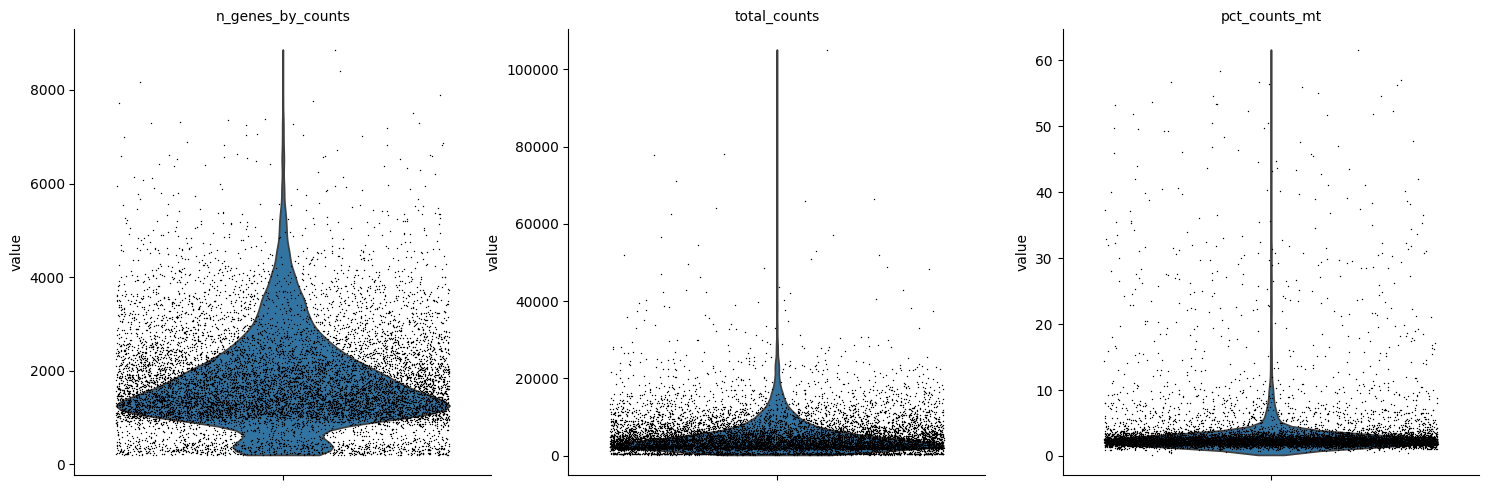

In [12]:
# Plot QCs
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

## Doublet removal

In [13]:
sc.pp.scrublet(adata, batch_key="sample")

## Plot counts and mitochondrial counts

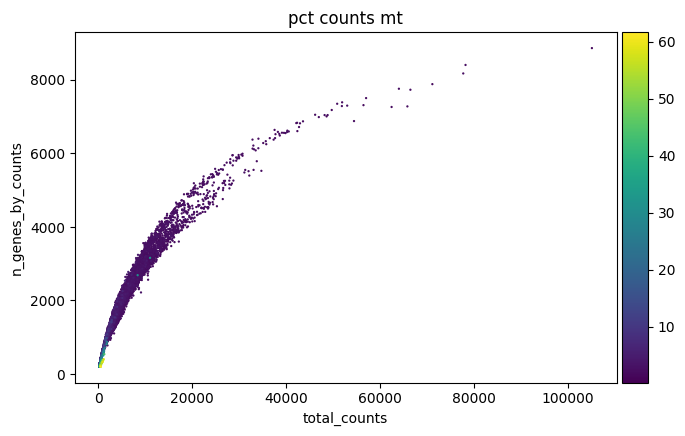

In [14]:
sc.pl.scatter(
    adata,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt")

In [15]:
adata.shape

(11059, 16521)

## Normalization

In [16]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [17]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

In [18]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

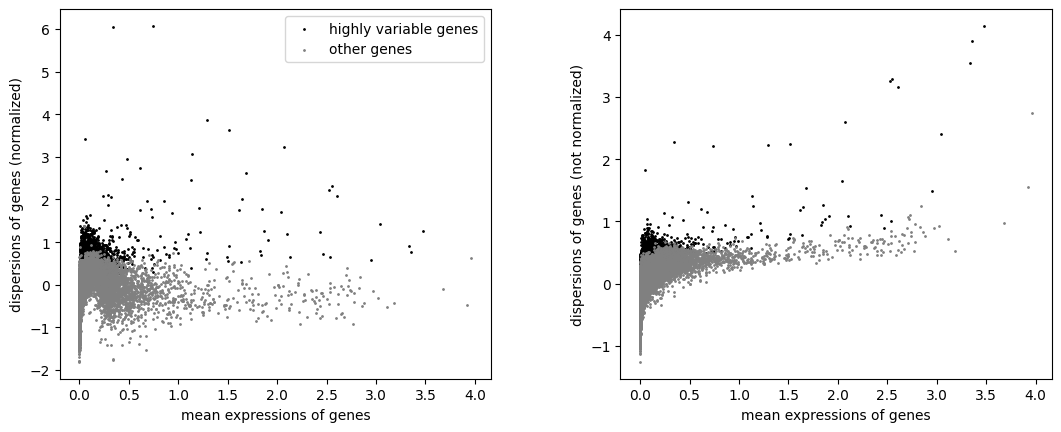

In [19]:
sc.pl.highly_variable_genes(adata)

## Dimensionality reduction

In [20]:
sc.tl.pca(adata)

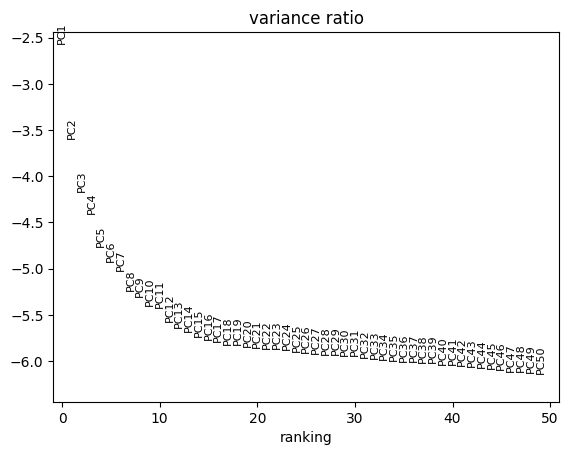

In [21]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

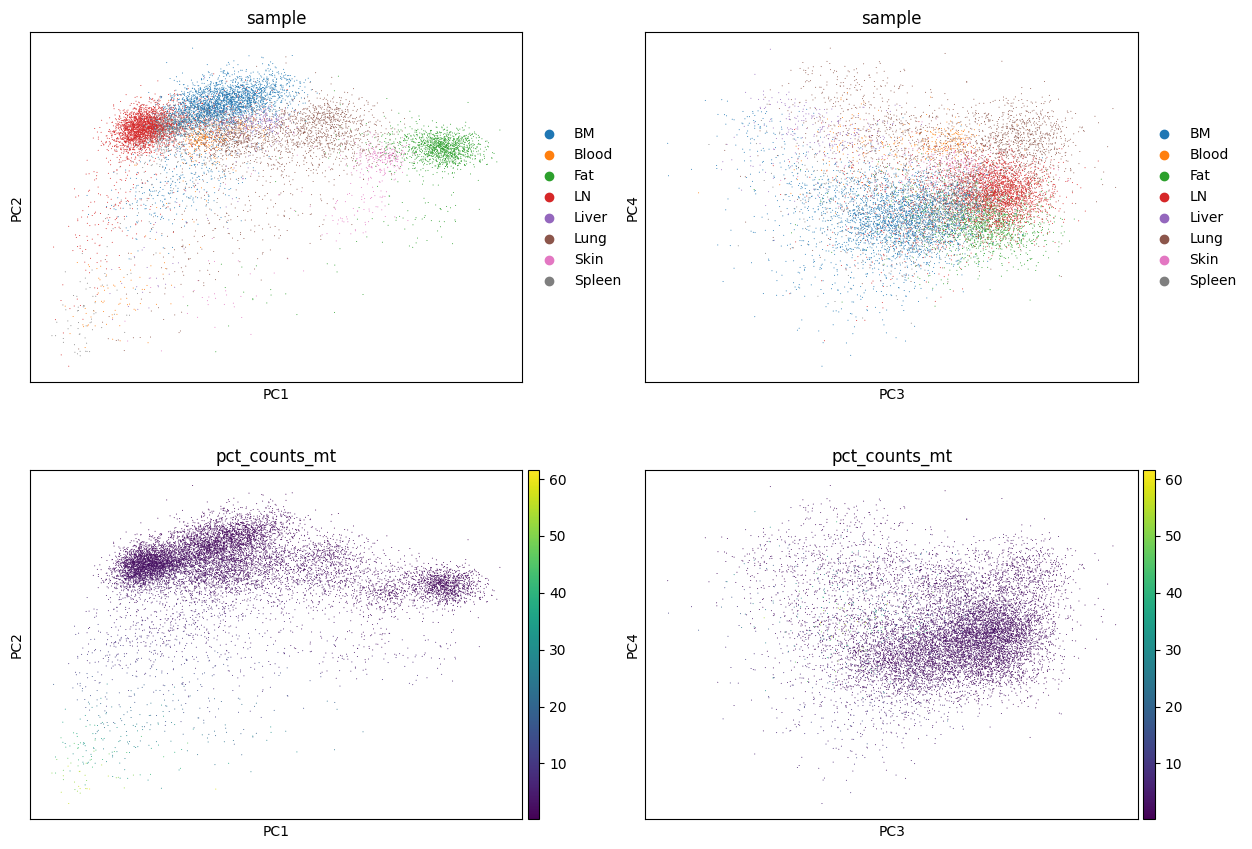

In [22]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Nearest neighbor graph

In [23]:
sc.pp.neighbors(adata)

/home/nikiarte/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
sc.tl.umap(adata)

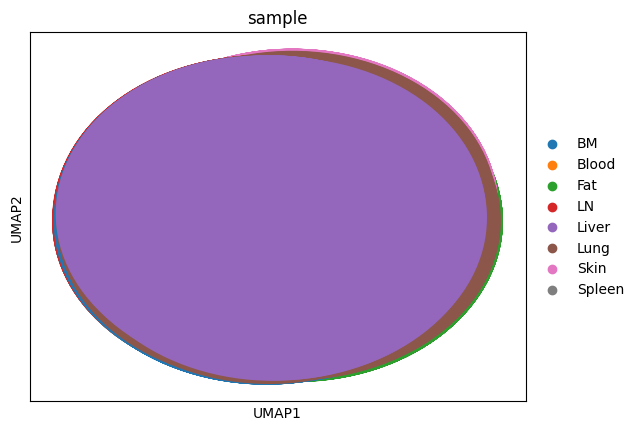

In [96]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=20,
    scale_factor=0.2
)

## Clustering

In [26]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

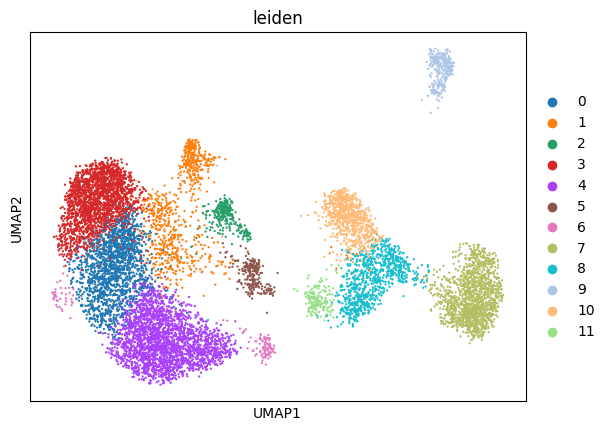

In [27]:
sc.pl.umap(adata, color=["leiden"])

## Reassessing QC

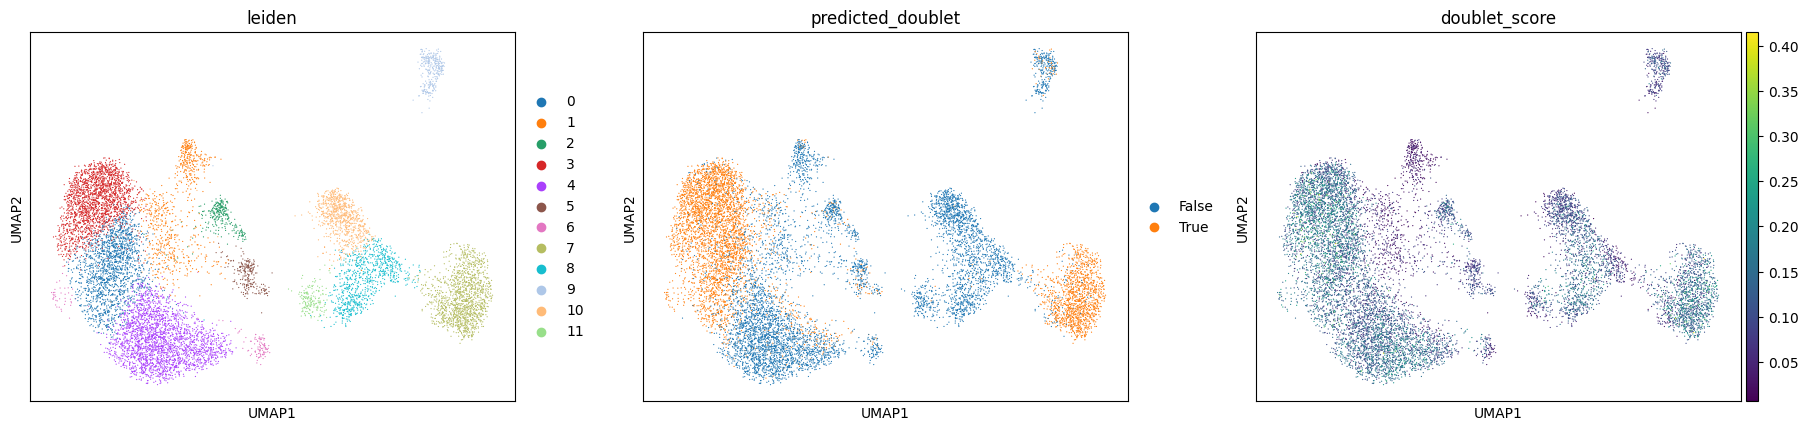

In [28]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.15,
    size=3,
)

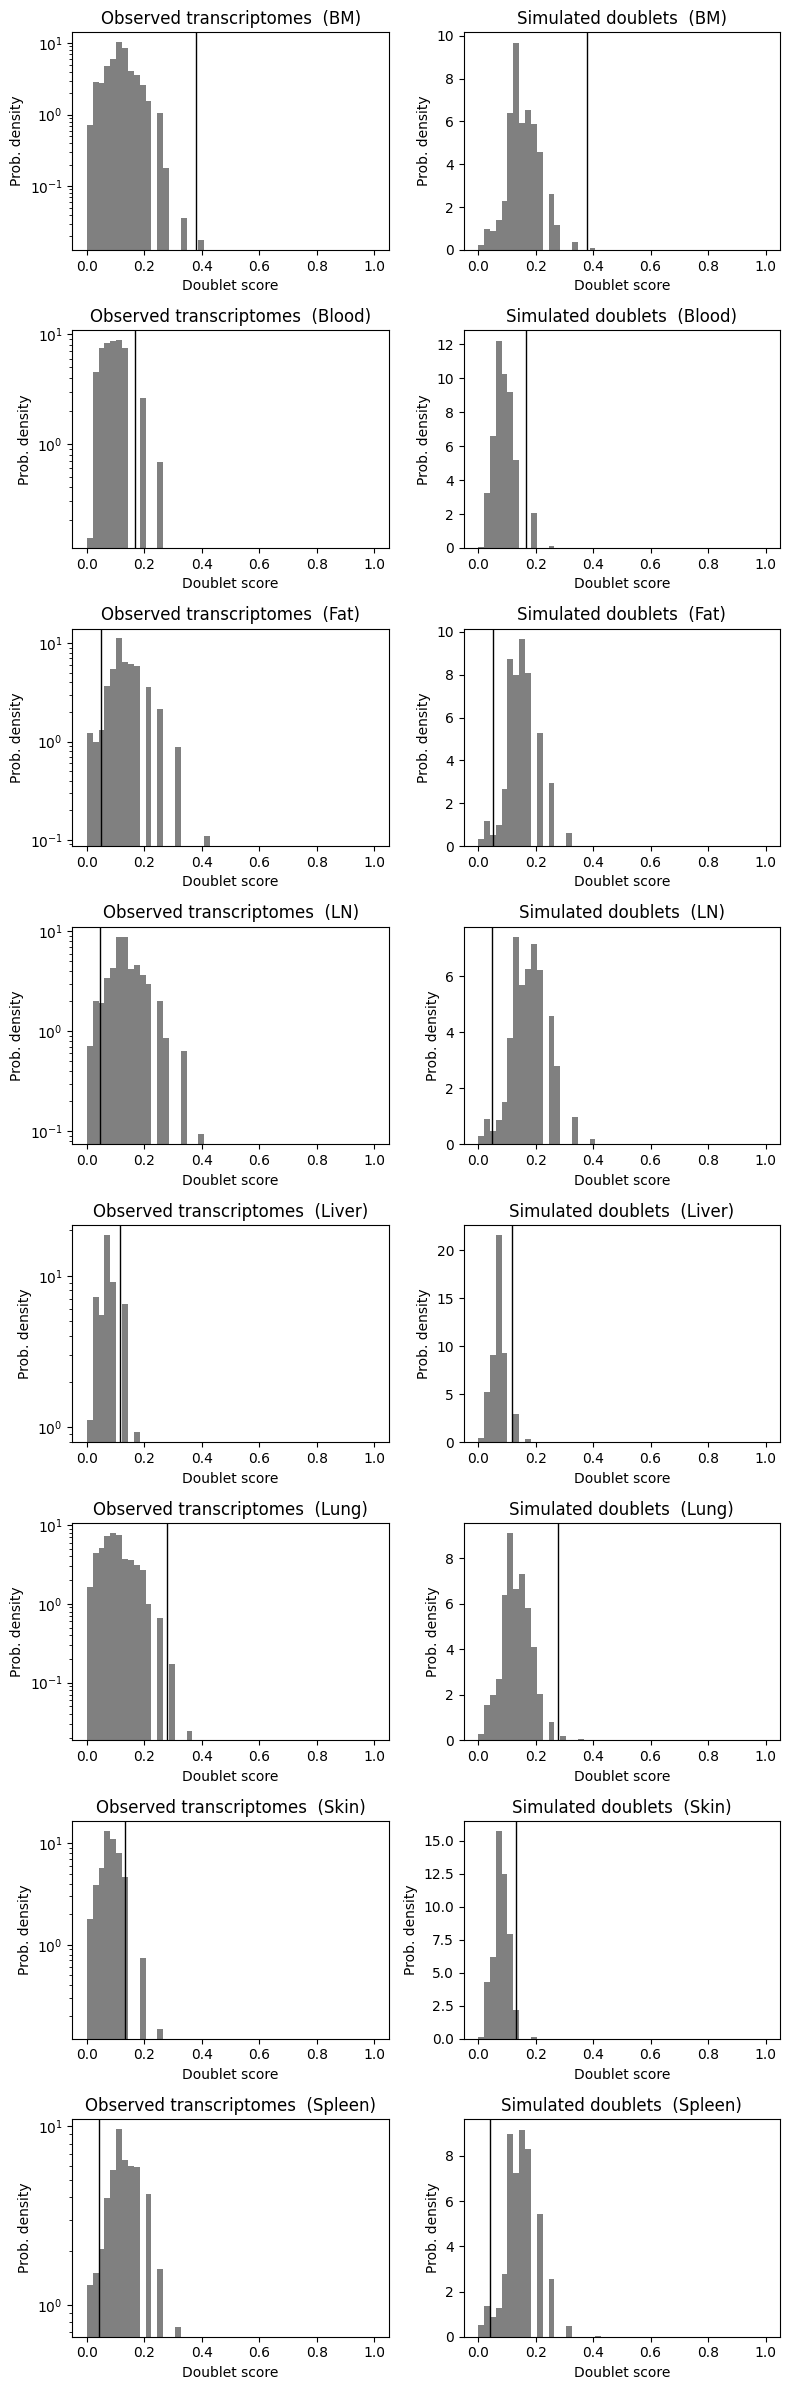

In [29]:
sc.pl.scrublet_score_distribution(adata)

In [30]:
# Doublet filter
#adata = adata[adata.obs.doublet_score <= 0.2]

In [31]:
# Mitochondria and surplus reads filter
# Filter cells with too many counts

# upper_lim = np.quantile(
#     adata.obs.n_genes_by_counts.values,
#     0.98)
# adata = adata[adata.obs.n_genes_by_counts < upper_lim]

# Filter cells with more than 20% mitochondrial reads
# adata = adata[adata.obs.pct_counts_mt < 20]

## Re-plot with filters

In [32]:
sc.pp.neighbors(adata)

In [33]:
sc.tl.umap(adata)

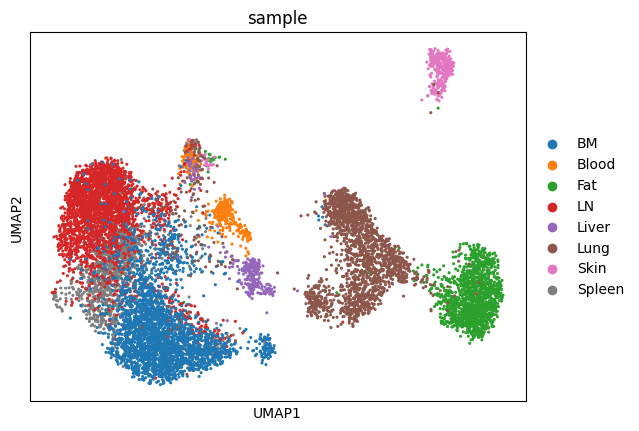

In [34]:
# UMAP with doublet filter

sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=20,
)

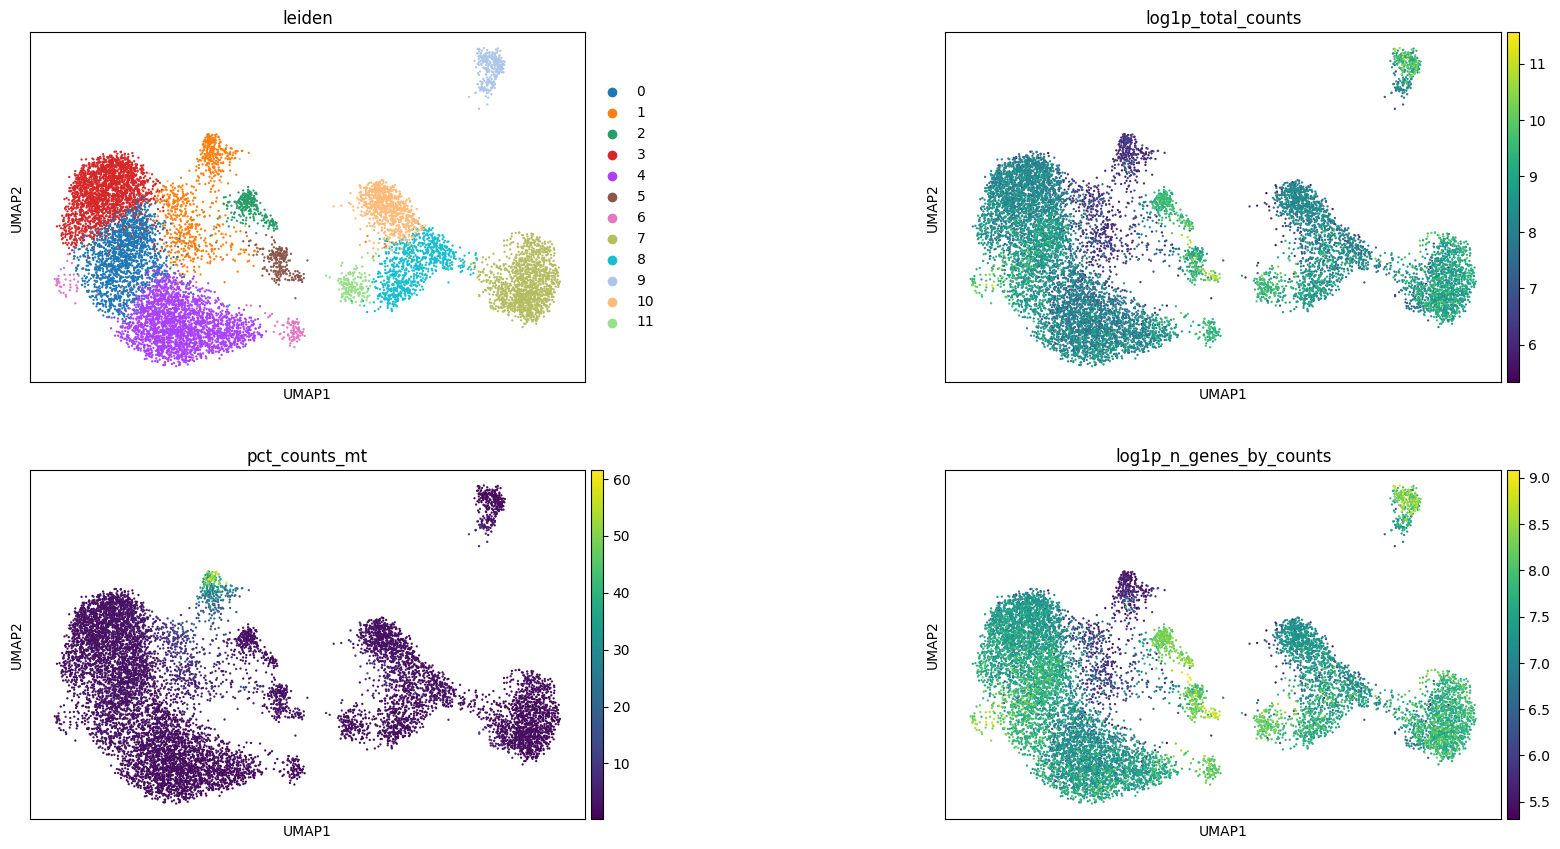

In [35]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

## Cell annotation

In [36]:
for res in [0.02, 0.52, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

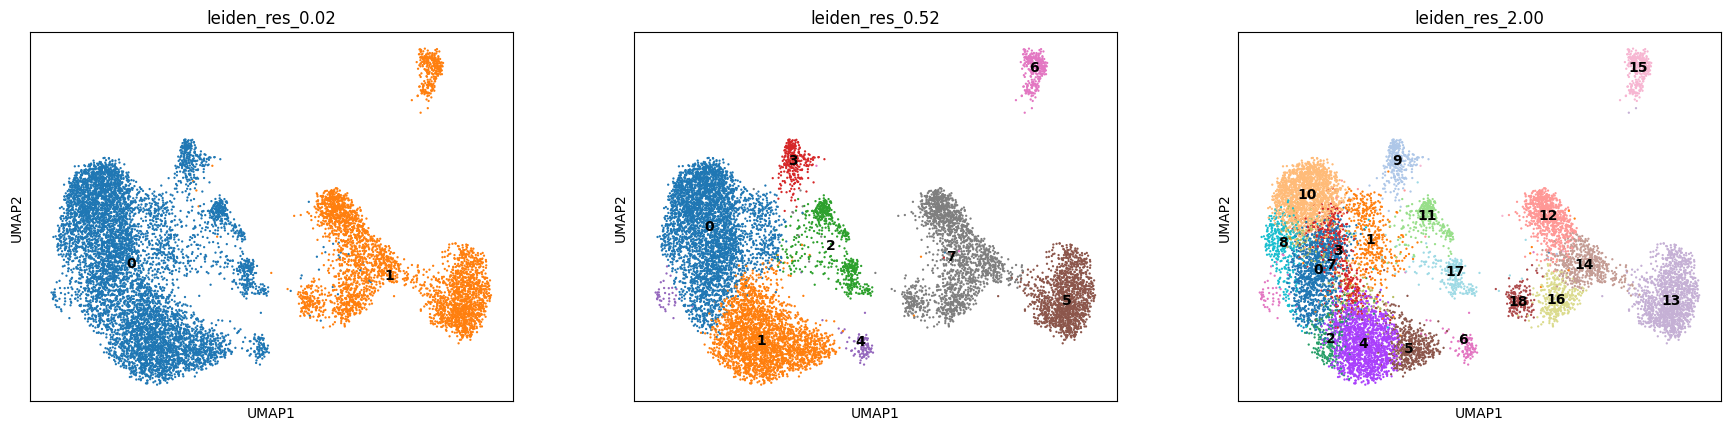

In [37]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.52", "leiden_res_2.00"],
    legend_loc="on data",
)

## Marker gene set from Differential Expression

In [38]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.52", method="wilcoxon")

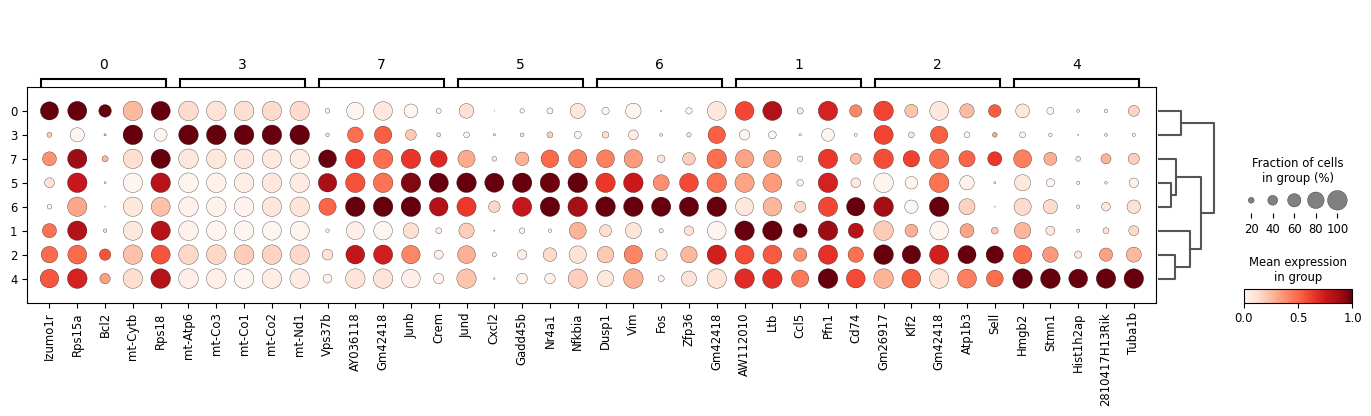

In [39]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.52", standard_scale="var", n_genes=5
)

In [40]:
# Top expressed genes in Fat Treg
sc.get.rank_genes_groups_df(adata, group="5").head(20)

names     scores  logfoldchanges  pvals  pvals_adj
0       Jund  56.943367        3.215254    0.0        0.0
1      Cxcl2  56.166374        6.252323    0.0        0.0
2    Gadd45b  56.007835        4.444253    0.0        0.0
3      Nr4a1  55.378288        4.105432    0.0        0.0
4     Nfkbia  55.227966        2.792222    0.0        0.0
5       Areg  53.679146        4.417136    0.0        0.0
6       Lmna  53.569363        4.166308    0.0        0.0
7     S100a6  53.098698        3.207824    0.0        0.0
8       Junb  53.012123        3.020746    0.0        0.0
9     Il1rl1  53.006092        3.467560    0.0        0.0
10  AA467197  52.940334        6.681938    0.0        0.0
11      Odc1  52.422882        3.049384    0.0        0.0
12      Il10  52.349953        5.240431    0.0        0.0
13    Ctla2a  52.285606        3.450659    0.0        0.0
14      Rgs2  52.051212        3.804332    0.0        0.0
15    Hilpda  50.735241        4.000844    0.0        0.0
16    S100a4  50.634811        3.171948    0.0        0.0
17    Nfkbiz  50.620934        2.968423    0.0        0.0
18    Nfkbid  50.567650        3.460543    0.0        0.0
19     Klrg1  50.470329        2.680537    0.0        0.0

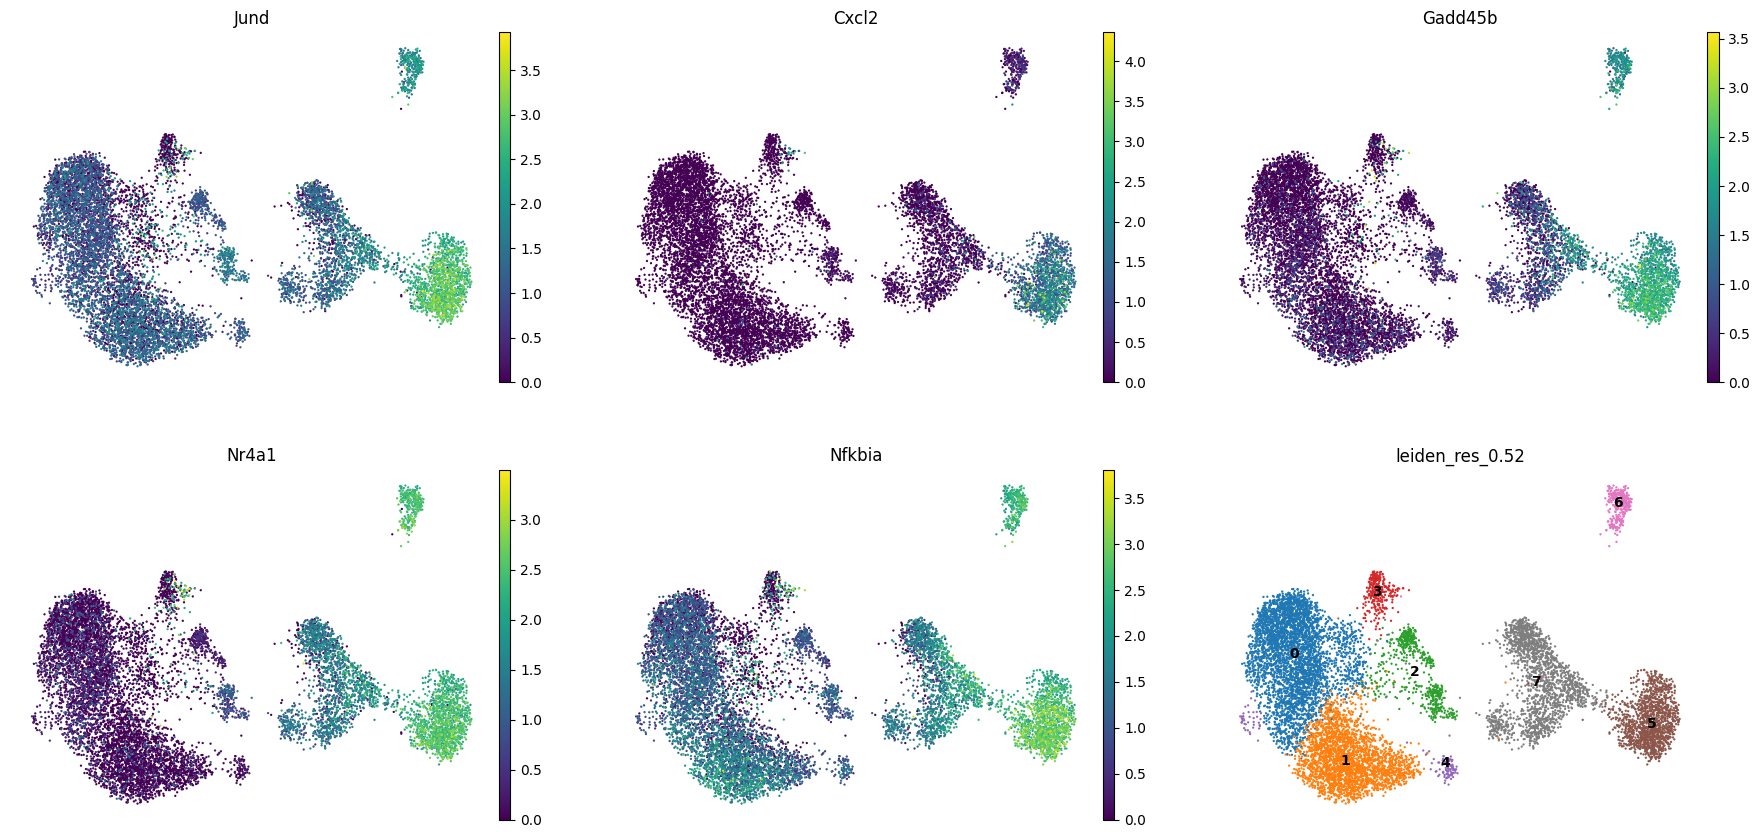

In [41]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="5").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.52"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

## Checking expression of the genes of interest

### Rora

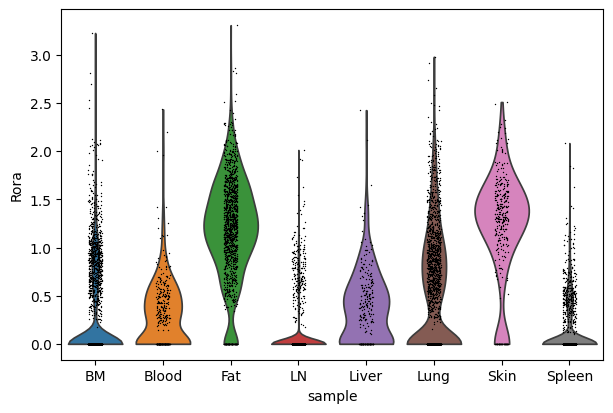

In [42]:
sc.pl.violin(adata, ["Rora"], groupby="sample")

vmax scaled to 99th percentile + 20%:  2.45


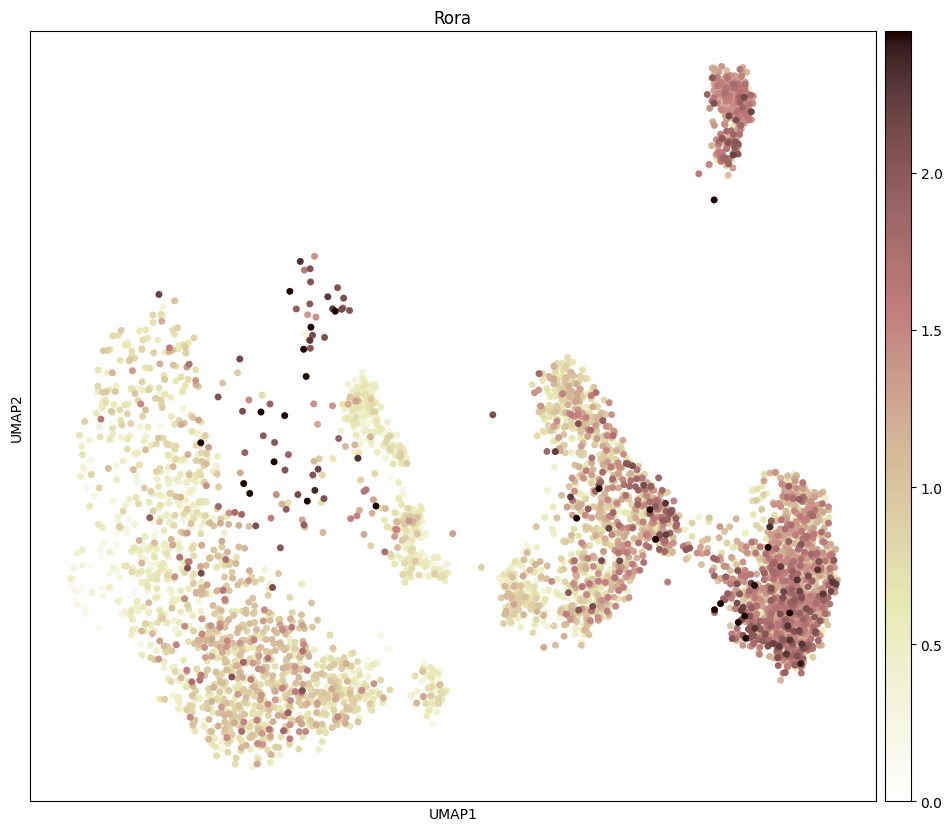

In [137]:
# Interesting autophagy genes
with rc_context({"figure.figsize": (12, 10)}):
    sc.pl.umap(
        adata,
        cmap="pink_r",
        size=100,
        color="Rora",
        vmax=scaled_vmax
    )

### Autophagy genes

#### Violin plots

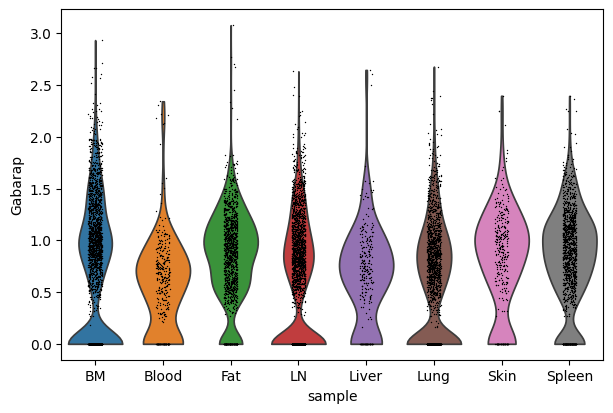

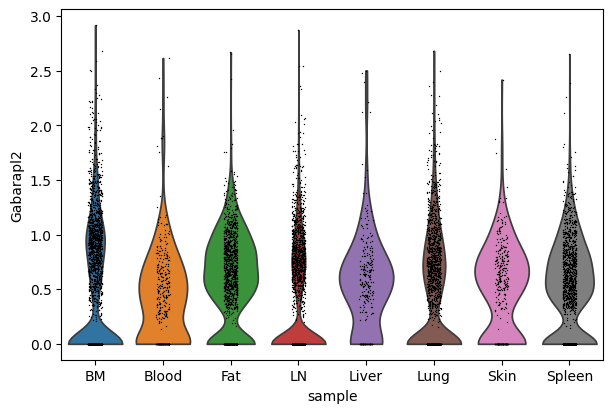

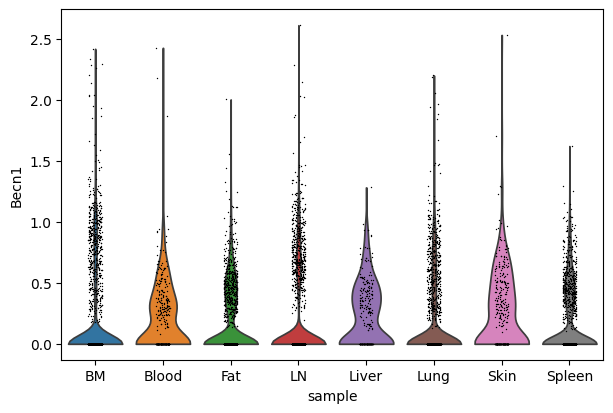

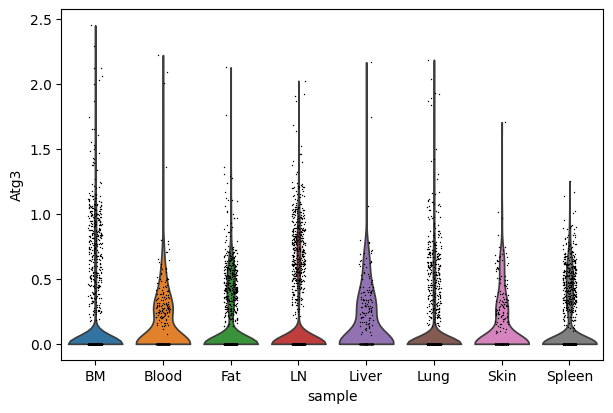

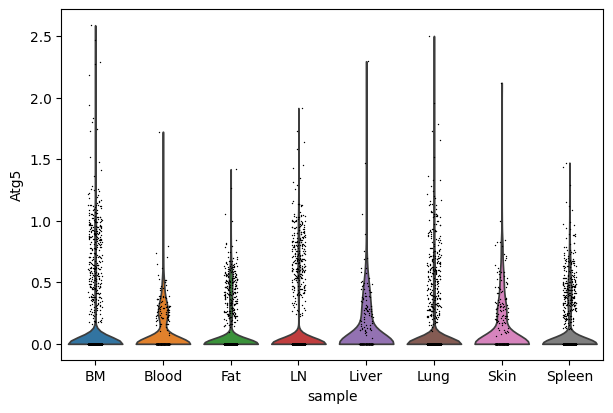

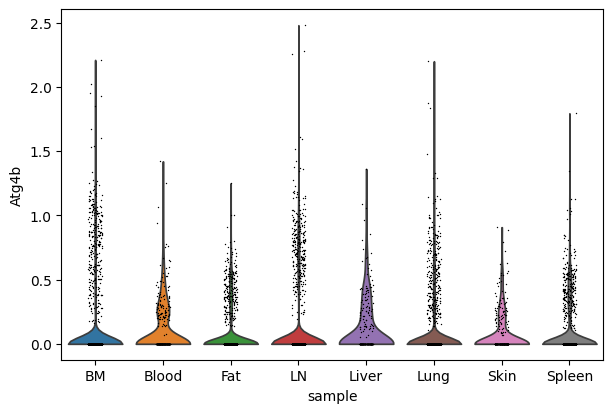

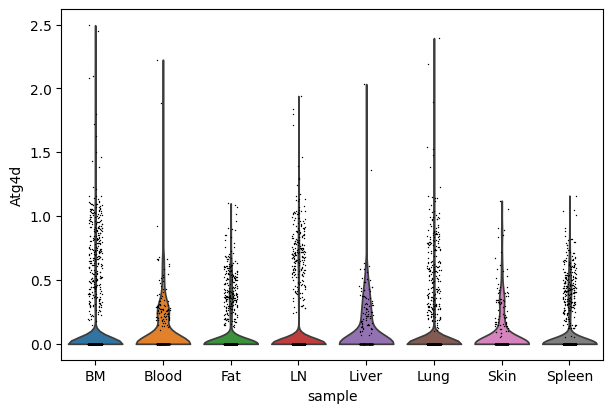

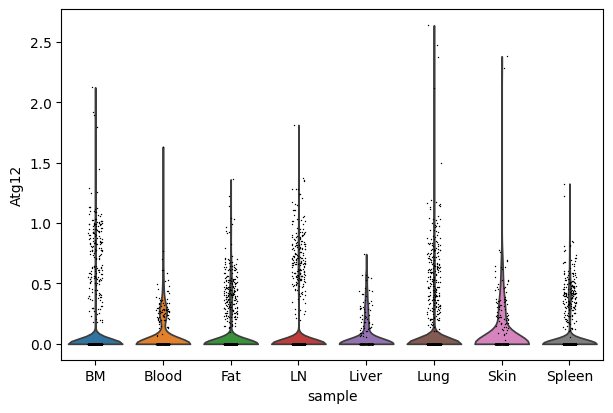

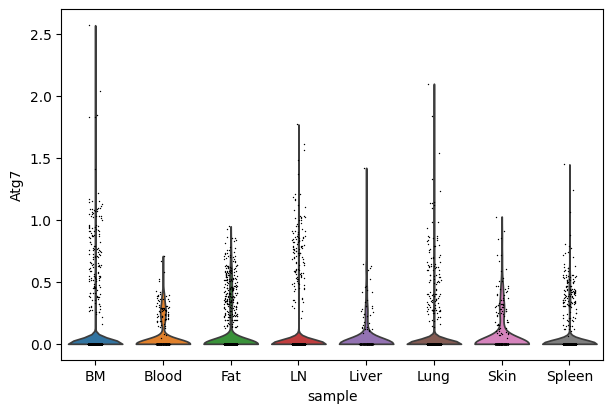

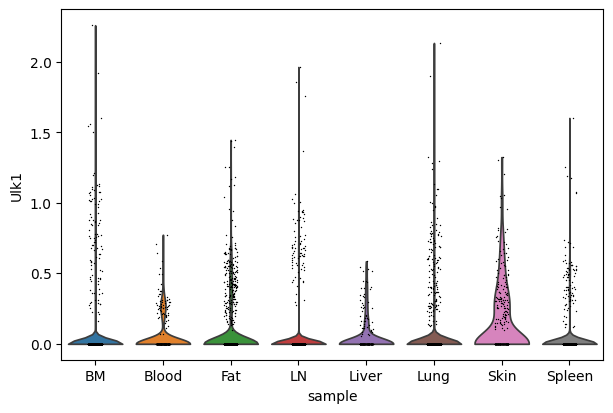

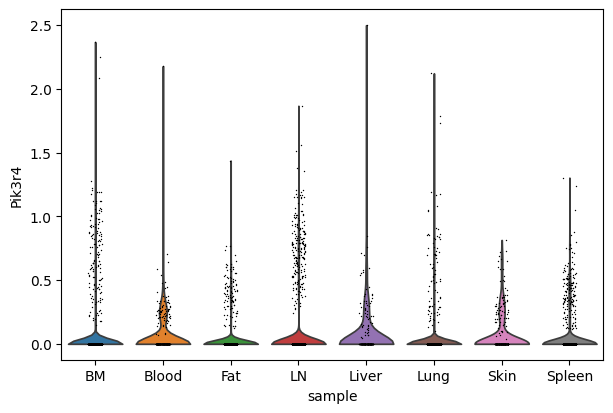

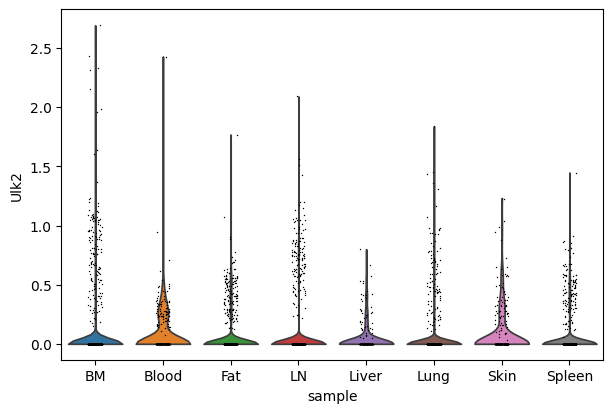

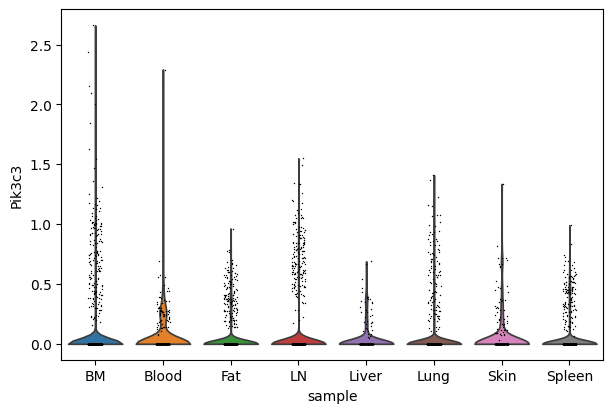

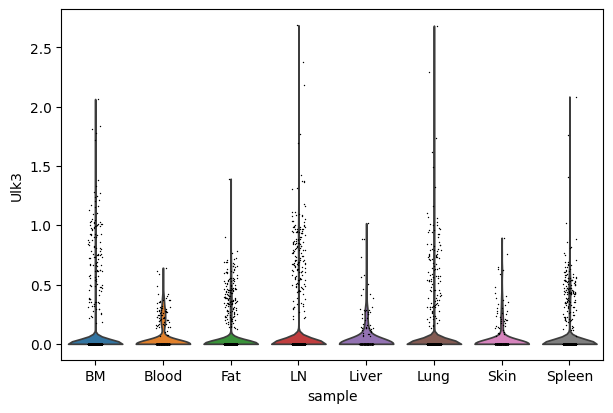

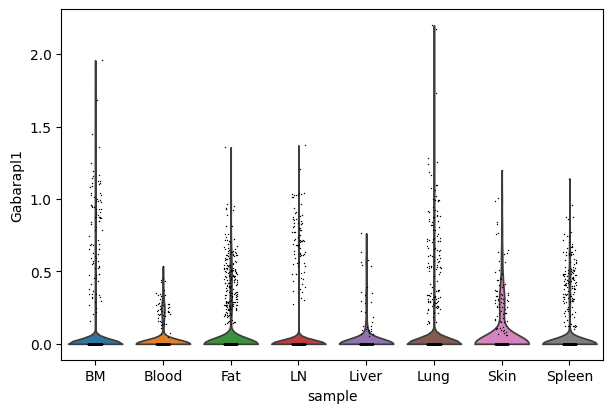

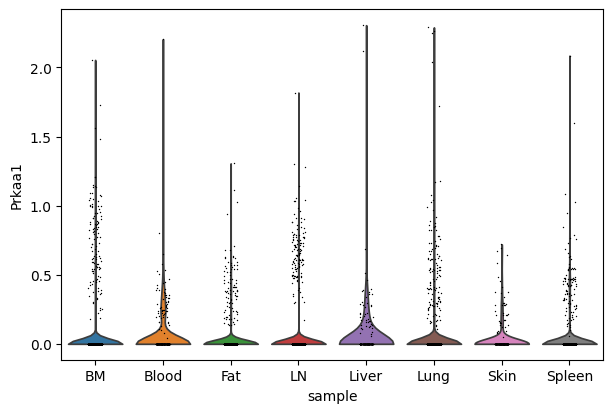

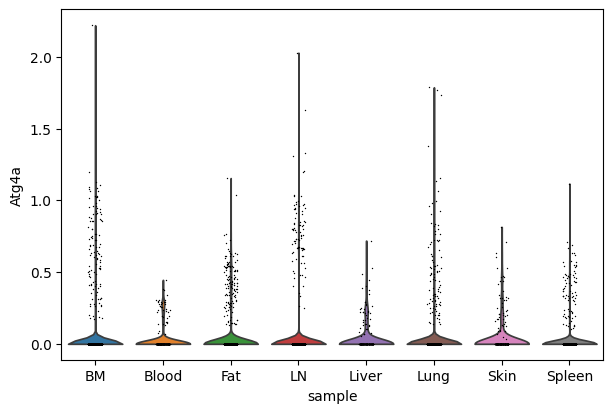

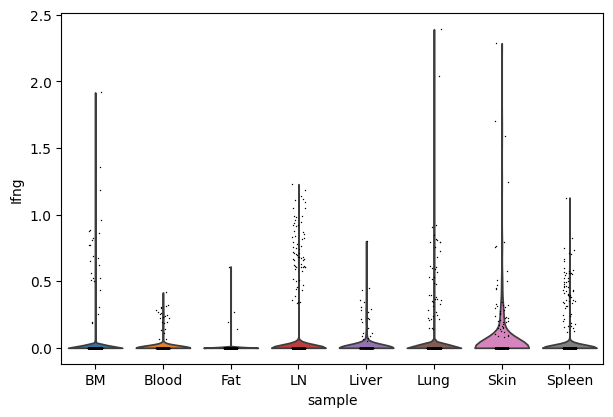

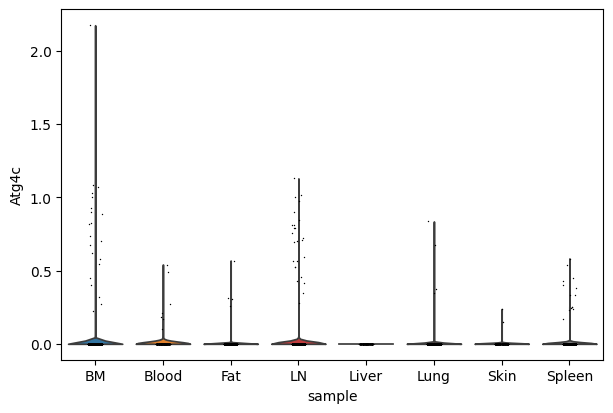

In [70]:
# Checking Autophagy-related genes in Tregs in various tissues

autophagy_geneset = ["Atg12", "Atg3", "Atg4a", "Atg4b", "Atg4c",
                     "Atg4d", "Atg5", "Atg7", "Becn1", "Becn2",
                     "Gabarap", "Gabarapl1", "Gabarapl2", "Ifna1",
                     "Ifna10", "Ifna13", "Ifna14", "Ifna16", "Ifna17",
                     "Ifna2", "Ifna21", "Ifna4", "Ifna5", "Ifna6", "Ifna7",
                     "Ifna8", "Ifng", "Ins", "Pik3c3", "Pik3r4", "Prkaa1",
                     "Prkaa2", "Ulk1", "Ulk2", "Ulk3"]


autophagy_genset_in_data = [k for k in list(adata.var_names) if k in autophagy_geneset]

# Sort genes by mean counts to get the most relevant first

autophagy_genes_df = adata.var.loc[autophagy_genset_in_data]
autophagy_genes_df.sort_values("mean_counts", ascending=False, inplace=True)
sorted_autophagy_genes_list = list(autophagy_genes_df.index)

for gene in sorted_autophagy_genes_list:
    sc.pl.violin(adata,
                 gene,
                 groupby="sample"
                )

In [ ]:
sc.pl.violin(adata, ["Atg7"], groupby="leiden_res_0.52")

In [ ]:
sc.pl.violin(adata, ["Atg101"], groupby="leiden_res_0.52")

#### UMAP Plots

vmax scaled to 99th percentile + 20%:  2.36


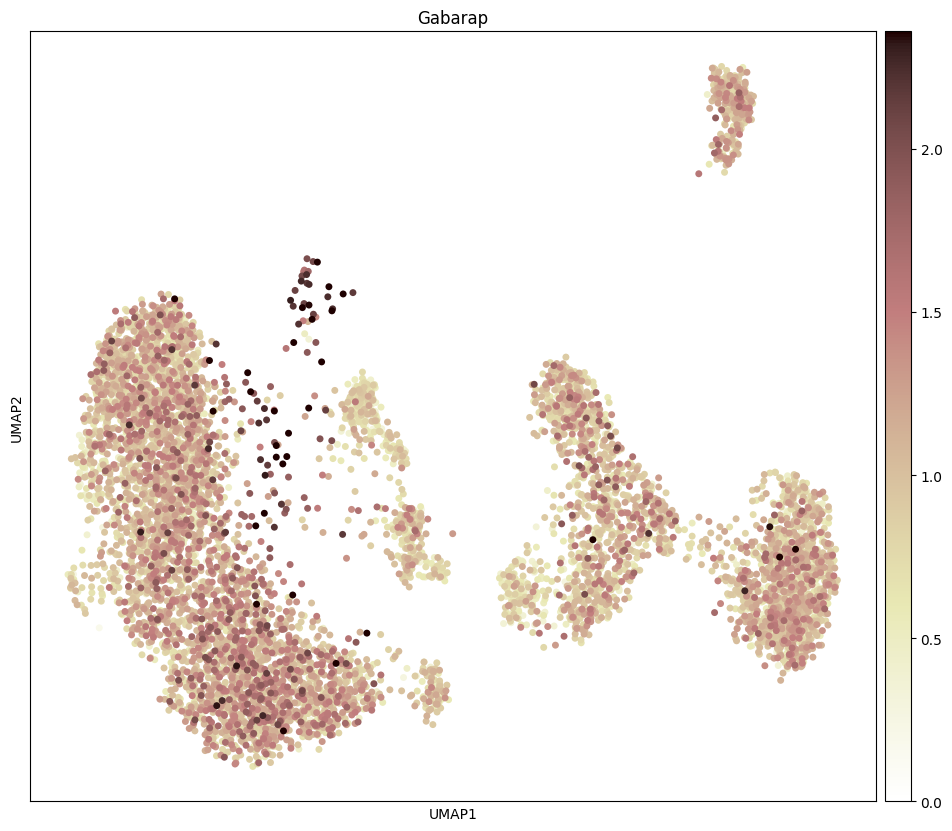

vmax scaled to 99th percentile + 20%:  2.18


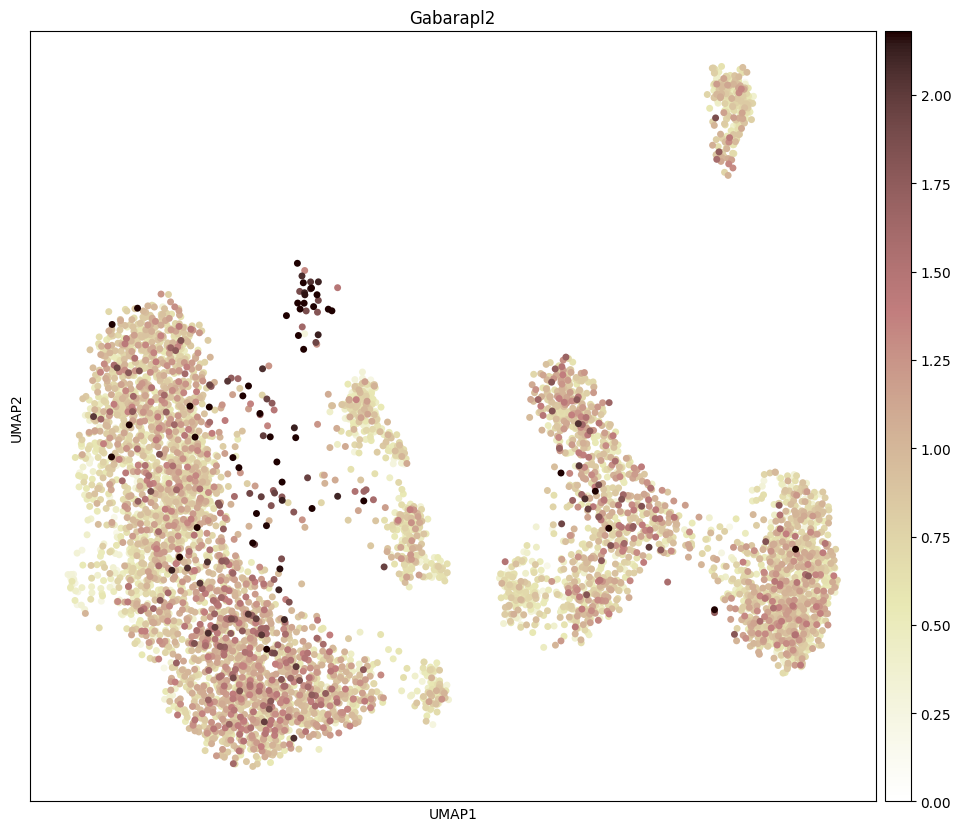

vmax scaled to 99th percentile + 20%:  1.47


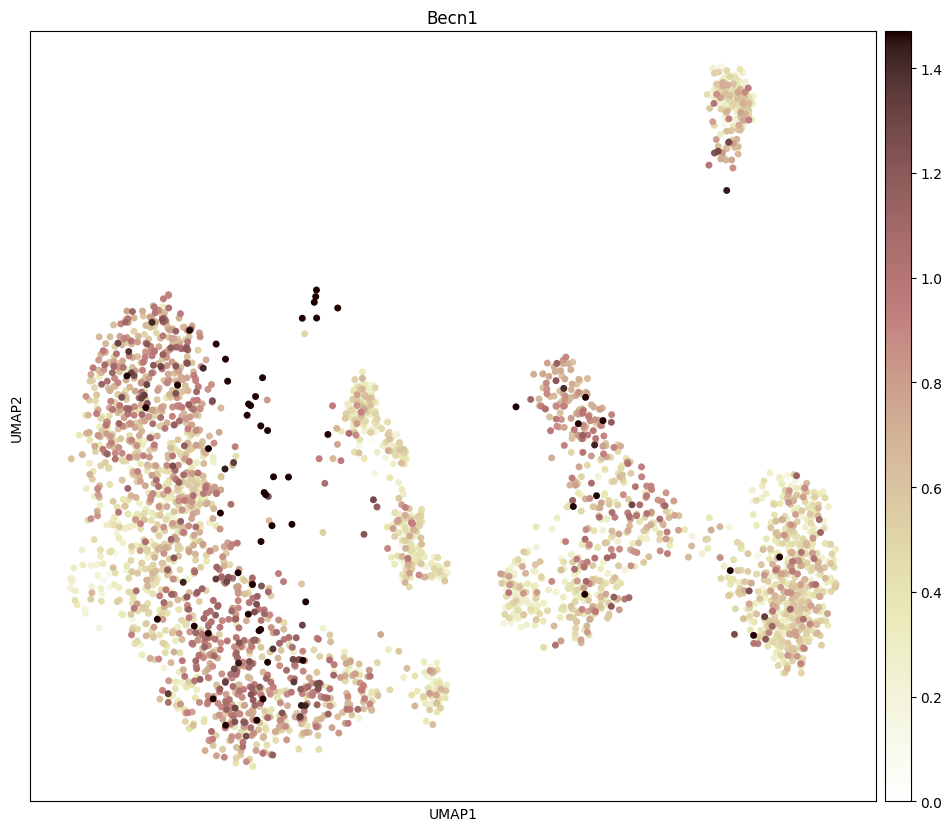

vmax scaled to 99th percentile + 20%:  1.36


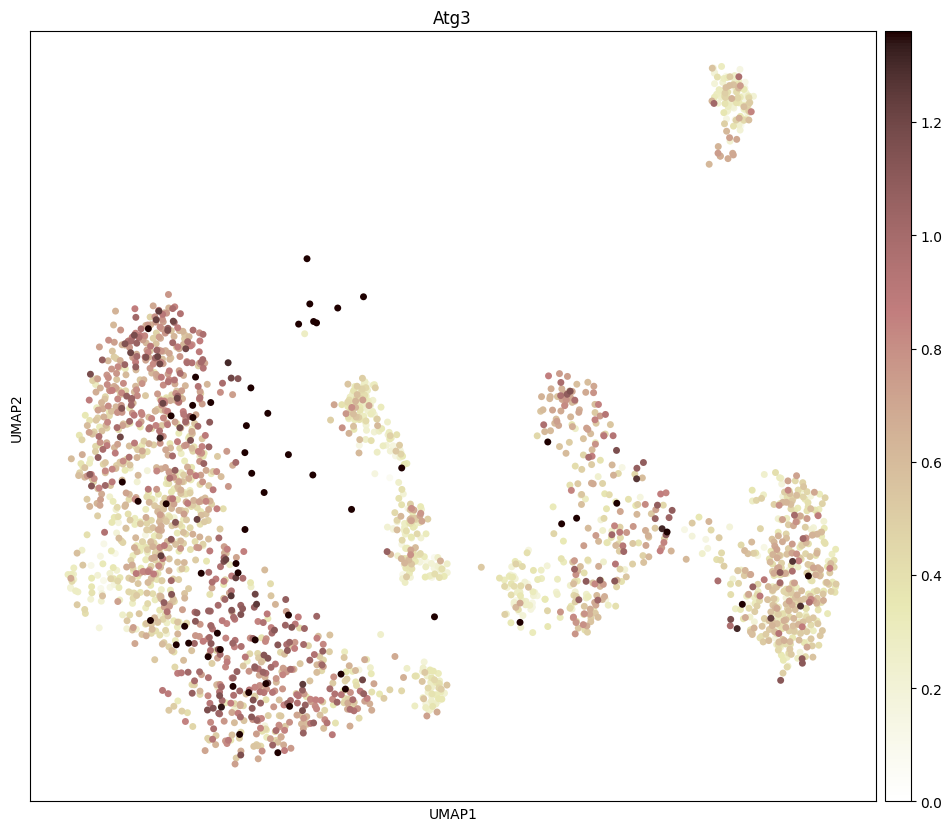

In [139]:
GENES = ["Gabarap", "Gabarapl2", "Becn1", "Atg3"]

# Started implementing pallete color normalization
# vmin = adata.var.loc[GENE].min()
# vmax = adata.var.loc[GENE].max()
# vpadding = (vmax - vmin) * 0.2
# norm = MidpointNormalize(vmin=vmin - vpadding, vmax=vmax + vpadding, midpoint=0)


# rc_context is used for the figure size, in this case 4x4
for gene in GENES:
    with rc_context({"figure.figsize": (12, 10)}):
        sc.pl.umap(
            adata,
            cmap="pink_r",
            color=gene,
            size=100,
            vmax=scaled_vmax
        )

In [ ]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(
    adata,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

In [ ]:
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        adata,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

## Trajectories

In [ ]:
# WARNING: Alternative preprocessing here
DO_ALT_PREPROC = False

In [ ]:
if DO_ALT_PREPROC:
    settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
    sc.logging.print_versions()
    results_file = "./write/paul15.h5ad"
    # low dpi (dots per inch) yields small inline figures
    sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

In [ ]:
if DO_ALT_PREPROC:
    sc.pp.recipe_zheng17(adata)

In [ ]:
if DO_ALT_PREPROC:
    sc.tl.pca(adata, svd_solver="arpack")

In [ ]:
if DO_ALT_PREPROC:
    sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
    sc.tl.draw_graph(adata)

In [ ]:
with rc_context({"figure.figsize": (15, 15)}):
    sc.pl.draw_graph(
        adata,
        color="sample",
        size=100,
        legend_loc="on data",
        legend_fontsize=30,
        legend_fontoutline=2,
    )

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_diffmap")

In [ ]:
sc.tl.draw_graph(adata)

In [ ]:
with rc_context({"figure.figsize": (15, 15)}):
    sc.pl.draw_graph(
        adata,
        color="sample",
        size=100,
        legend_loc="on data",
        legend_fontsize=30,
        legend_fontoutline=2,)

In [ ]:
sc.tl.leiden(adata, resolution=0.52)

In [ ]:
sc.tl.paga(adata, groups="leiden")

In [ ]:
with rc_context({"figure.figsize": (15, 15)}):
    sc.pl.paga(
        adata,
        color=["Klrg1"]
    )

In [ ]:
adata.obs["leiden"].cat.categories

In [ ]:
adata.obs["leiden_anno"] = adata.obs["leiden"]